### Import the required packages

In [14]:
import torch
import random
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

### Load the data and create the Train, Validation and Test datasets

In [4]:
# Used for finding the mean and std of the dataset
#mean = X_train.train_data.float().mean() / 255 # = 0.1307
#std = X_train.train_data.float().std() / 255 # = 0.3081

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

### Check the data

In [ ]:
print(f'train_dataset data shape: {train_dataset.dataset.data[train_dataset.indices].shape}')
print(f'train_dataset targets shape: {train_dataset.dataset.targets[train_dataset.indices].shape}')

print(f'val_dataset data shape: {val_dataset.dataset.data[val_dataset.indices].shape}')
print(f'val_dataset targets shape: {val_dataset.dataset.targets[val_dataset.indices].shape}')

print(f'test_dataset data shape: {test_dataset.data.shape}')
print(f'test_datset targets shape: {test_dataset.targets.shape}')

print(f'Classes: {train_dataset.dataset.classes}')

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_dataset.dataset.data[train_dataset.indices][i], cmap='gray')
    plt.xlabel(f'Label: {train_dataset.dataset.targets[train_dataset.indices][i]}')

### Check the data distribution

In [ ]:
y_train = train_dataset.dataset.targets[train_dataset.indices].numpy()
y_val = val_dataset.dataset.targets[val_dataset.indices].numpy()
y_test = test_dataset.targets.numpy()
    
datasets = {
    'Train': y_train,
    'Val': y_val,
    'Test': y_test
}
    
data = []
for set_name, y_data in datasets.items():
    unique, counts = np.unique(y_data, return_counts=True)
    for digit, count in zip(unique, counts):
        data.append({
            'Dataset': set_name,
            'Digit': digit,
            'Count': count
        })
    
df = pd.DataFrame(data)
    
plt.figure(figsize=(15, 8))
df_pivot = df.pivot(index='Digit', columns='Dataset', values='Count')
df_pivot.plot(kind='bar', width=0.8)
    
plt.title('Digit distribution in MNIST datasets')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.legend(title='Dataset', loc='upper right')
plt.grid(True, alpha=0.3)
    
plt.show()

### Model class and helper functions

In [11]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()

        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out
    
def create_dataloaders(dataset, batch_size, num_workers, shuffle):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=True
    )
    
def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias) 

def create_model(input_size, n_neurons, num_classes, learning_rate, eta_minus, eta_plus, device):
    model = Net(input_size, n_neurons, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Rprop(
        model.parameters(),
        lr=learning_rate,
        etas=(eta_minus, eta_plus),
        step_sizes=(1e-6, 50)
    )

    model.apply(weights_init)

    return model, criterion, optimizer

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, patience, min_delta):
    train_losses = []
    val_losses = []
    val_accuracies = []
    patience_counter = 0
    best_val_loss = float('inf')
    best_model_state = None
    n_total_steps = len(train_loader)

    for epoch in range(num_epochs):
        
        total_train_loss = 0.0
        n_train_samples = 0

        # Training phase
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * labels.size(0)
            n_train_samples += labels.size(0)

        avg_train_loss = total_train_loss / n_train_samples
        train_losses.append(avg_train_loss)

        # Validation phase
        val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Early stopping check
        if best_val_loss - val_loss > min_delta:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        print(f'Epoch [{epoch+1}/{num_epochs}], Train loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return train_losses, val_losses, val_accuracies
    
def validate_model(model, val_loader, criterion, device):
    total_loss = 0.0
    n_samples = 0
    n_correct = 0
    
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            n_samples += labels.size(0)

            _, predicted = torch.max(outputs, 1)
            n_correct += (predicted == labels).sum().item()

        avg_loss = total_loss / n_samples
        accuracy = 100.0 * n_correct / n_samples
    
    return avg_loss, accuracy

def plot_results(train_losses, val_losses, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    epochs = range(1, len(train_losses) + 1)
    ax1.plot(epochs, train_losses, '--', label='Train', alpha=0.7)
    ax1.plot(epochs, val_losses, '-', label='Validation')
    
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot validation accuracy
    ax2.plot(epochs, val_accuracies, label='Validation')
    
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def plot_fold_results(fold_train_losses, fold_val_losses, fold_val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    for fold_idx, (train_losses, val_losses) in enumerate(zip(fold_train_losses, fold_val_losses)):
        epochs = range(1, len(train_losses) + 1)
        ax1.plot(epochs, train_losses, '--', label=f'Fold {fold_idx+1} (Train)', alpha=0.7)
        ax1.plot(epochs, val_losses, '-', label=f'Fold {fold_idx+1} (Val)')
    
    ax1.set_title('Training and Validation Loss per Fold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot validation accuracies
    for fold_idx, acc in enumerate(fold_val_accuracies):
        epochs = range(1, len(acc) + 1)
        ax2.plot(epochs, acc, label=f'Fold {fold_idx+1}')
    
    ax2.set_title('Validation Accuracy per Fold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def show_kfold_results(trial_results):
    results_df = pd.DataFrame([
        {
            'N': tr[0]['n_neurons'],
            'eta+': tr[0]['eta_plus'],
            'eta-': tr[0]['eta_minus'],
            'Accuracy (%)': f"{tr[1]:.2f} ± {tr[2]:.2f}",
            'Loss': f"{tr[3]:.4f} ± {tr[4]:.4f}",
            'Convergence (epochs)': f"{tr[5]:.1f} ± {tr[6]:.1f}"
        }
        for tr in trial_results
    ])

    fig, ax = plt.subplots(figsize=(12, len(trial_results)/2))
    ax.axis('tight')
    ax.axis('off')

    table = ax.table(
        cellText=results_df.values,
        colLabels=results_df.columns,
        cellLoc='center',
        loc='center',
        colColours=['#f2f2f2']*len(results_df.columns)
    )

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)

    plt.title("Hyperparameter Search Results", pad=20)
    plt.show()

def plot_confusion_matrix(model, test_loader, device):
    # Initialize variables
    y_pred = []
    y_true = []
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.numpy())
            
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Print accuracy metrics
    accuracy = accuracy_score(y_true, y_pred)
    print(f'\nAccuracy: {accuracy:.4f}')
    print('\nClassification Report:')
    print(classification_report(y_true, y_pred))
    
    plt.show()

### Model definition, training and testing (no kfold for fast evaluation)

In [ ]:
seed = 42

set_seed(seed)

device = get_device()

# Hyperparameters for the neural network
input_size = 784
n_neurons = 250
num_classes = 10

# Hyperparameters for the training
num_epochs = 300
batch_size = len(train_dataset)
learning_rate = 0.01

# Hyperparameters for the Rprop optimizer
eta_minus = 0.5
eta_plus = 1.07

# Hyperparameters for early stopping
patience = 3
min_delta = 0.040

train_loader = create_dataloaders(train_dataset, batch_size, num_workers=8, shuffle=True)
val_loader = create_dataloaders(val_dataset, batch_size, num_workers=8, shuffle=False)
test_loader = create_dataloaders(test_dataset, batch_size, num_workers=8, shuffle=False)

model, criterion, optimizer = create_model(
    input_size, 
    n_neurons, 
    num_classes, 
    learning_rate, 
    eta_minus, 
    eta_plus, 
    device
)

train_losses, val_losses, val_accuracies = train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    device, 
    num_epochs, 
    patience,
    min_delta, 
)

plot_results(train_losses, val_losses, val_accuracies)

### Model testing

In [ ]:
_, acc = validate_model(model, test_loader, criterion, device)
print(f'Test accuracy: {acc:.2f}%')

plot_confusion_matrix(model, test_loader, device)

### KFold cross validation with random search


Trial 1/10
Testing parameters: {'n_neurons': 150, 'eta_minus': 0.25, 'eta_plus': 1.05}
FOLD 1/5
Epoch [1/300], Train loss: 3.0018, Val Loss: 3.8606, Val Acc: 36.22%
Epoch [2/300], Train loss: 3.8730, Val Loss: 4.1956, Val Acc: 49.94%
Epoch [3/300], Train loss: 4.1931, Val Loss: 2.7596, Val Acc: 58.94%
Epoch [4/300], Train loss: 2.7471, Val Loss: 1.4647, Val Acc: 69.26%
Epoch [5/300], Train loss: 1.4616, Val Loss: 0.8391, Val Acc: 77.47%
Epoch [6/300], Train loss: 0.8414, Val Loss: 0.6225, Val Acc: 82.35%
Epoch [7/300], Train loss: 0.6303, Val Loss: 0.5345, Val Acc: 84.81%
Epoch [8/300], Train loss: 0.5408, Val Loss: 0.4658, Val Acc: 86.96%
Epoch [9/300], Train loss: 0.4692, Val Loss: 0.4212, Val Acc: 88.11%
Epoch [10/300], Train loss: 0.4254, Val Loss: 0.3842, Val Acc: 89.20%
Epoch [11/300], Train loss: 0.3901, Val Loss: 0.3544, Val Acc: 89.90%
Epoch [12/300], Train loss: 0.3598, Val Loss: 0.3303, Val Acc: 90.42%
Epoch [13/300], Train loss: 0.3344, Val Loss: 0.3102, Val Acc: 91.20%
Ep

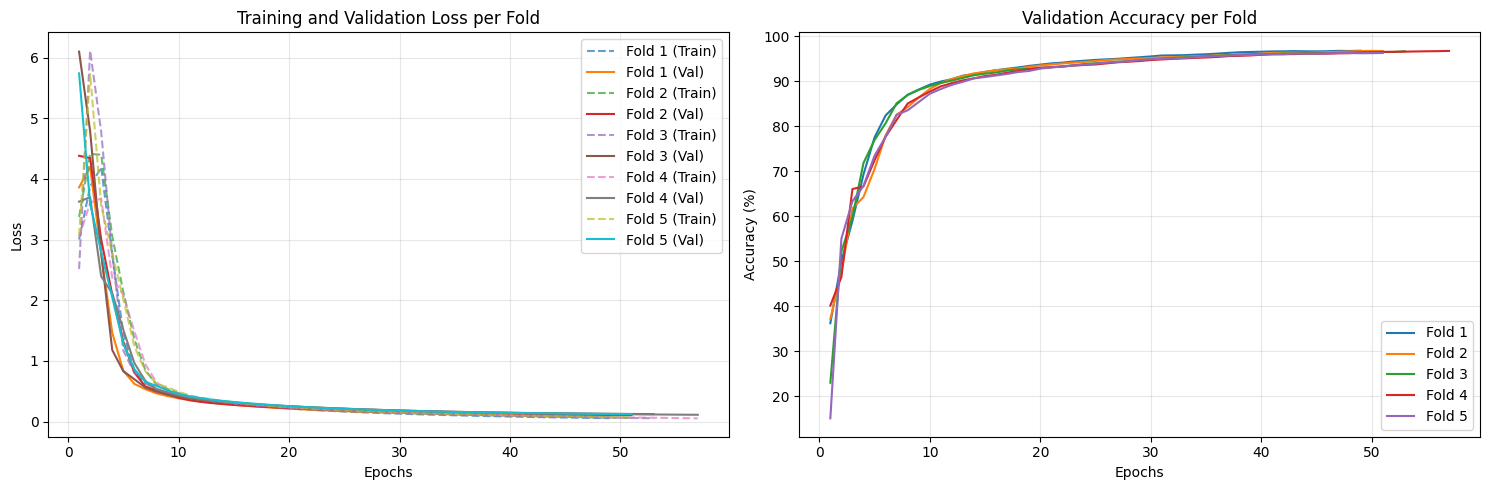


Trial 1 completed:
Parameters: {'n_neurons': 150, 'eta_minus': 0.25, 'eta_plus': 1.05}
Average accuracy across folds: 96.5917 ± 0.1857
Average validation loss: 0.1144 ± 0.0092
Average convergence epochs: 52.20 ± 2.71

Trial 2/10
Testing parameters: {'n_neurons': 150, 'eta_minus': 0.3, 'eta_plus': 1.05}
FOLD 1/5
Epoch [1/300], Train loss: 3.4393, Val Loss: 5.1789, Val Acc: 27.59%
Epoch [2/300], Train loss: 5.1875, Val Loss: 4.8465, Val Acc: 37.24%
Epoch [3/300], Train loss: 4.8515, Val Loss: 3.7423, Val Acc: 51.53%
Epoch [4/300], Train loss: 3.7425, Val Loss: 2.3200, Val Acc: 63.65%
Epoch [5/300], Train loss: 2.3299, Val Loss: 1.3020, Val Acc: 74.17%
Epoch [6/300], Train loss: 1.3187, Val Loss: 0.8451, Val Acc: 76.48%
Epoch [7/300], Train loss: 0.8576, Val Loss: 0.6504, Val Acc: 81.79%
Epoch [8/300], Train loss: 0.6628, Val Loss: 0.5264, Val Acc: 84.48%
Epoch [9/300], Train loss: 0.5398, Val Loss: 0.4361, Val Acc: 86.39%
Epoch [10/300], Train loss: 0.4538, Val Loss: 0.3829, Val Acc: 88

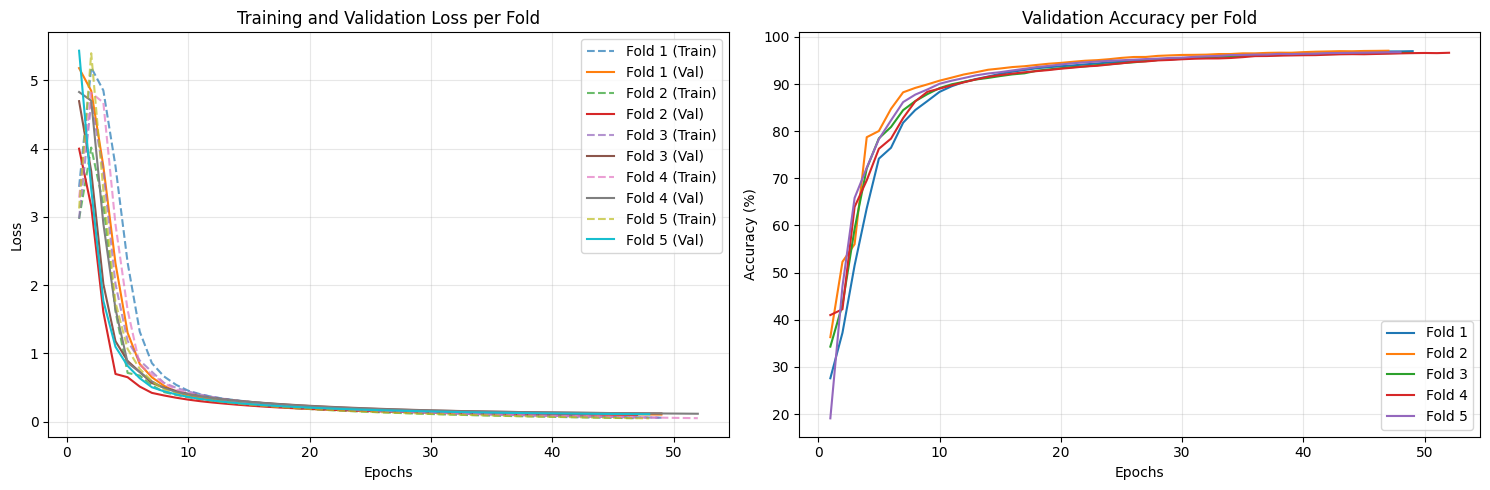


Trial 2 completed:
Parameters: {'n_neurons': 150, 'eta_minus': 0.3, 'eta_plus': 1.05}
Average accuracy across folds: 96.7958 ± 0.1890
Average validation loss: 0.1107 ± 0.0075
Average convergence epochs: 49.00 ± 1.67

Trial 3/10
Testing parameters: {'n_neurons': 200, 'eta_minus': 0.2, 'eta_plus': 1.15}
FOLD 1/5
Epoch [1/300], Train loss: 2.9718, Val Loss: 5.3738, Val Acc: 35.76%
Epoch [2/300], Train loss: 5.3979, Val Loss: 3.7361, Val Acc: 41.09%
Epoch [3/300], Train loss: 3.7680, Val Loss: 1.6472, Val Acc: 71.33%
Epoch [4/300], Train loss: 1.6606, Val Loss: 0.8883, Val Acc: 76.03%
Epoch [5/300], Train loss: 0.9097, Val Loss: 0.8042, Val Acc: 78.11%
Epoch [6/300], Train loss: 0.8390, Val Loss: 0.6545, Val Acc: 81.43%
Epoch [7/300], Train loss: 0.6872, Val Loss: 0.4824, Val Acc: 86.12%
Epoch [8/300], Train loss: 0.5040, Val Loss: 0.4122, Val Acc: 88.44%
Epoch [9/300], Train loss: 0.4239, Val Loss: 0.3765, Val Acc: 89.47%
Epoch [10/300], Train loss: 0.3865, Val Loss: 0.3404, Val Acc: 90.

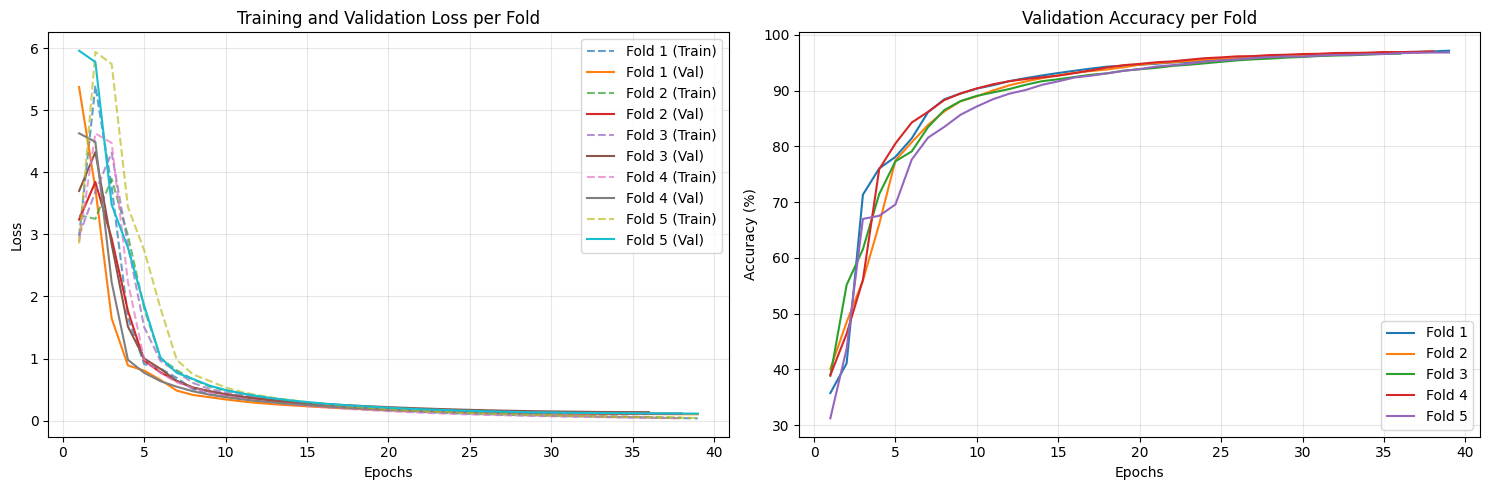


Trial 3 completed:
Parameters: {'n_neurons': 200, 'eta_minus': 0.2, 'eta_plus': 1.15}
Average accuracy across folds: 96.9208 ± 0.1890
Average validation loss: 0.1145 ± 0.0116
Average convergence epochs: 38.00 ± 1.10

Trial 4/10
Testing parameters: {'n_neurons': 170, 'eta_minus': 0.3, 'eta_plus': 1.1}
FOLD 1/5
Epoch [1/300], Train loss: 2.7323, Val Loss: 5.3097, Val Acc: 36.50%
Epoch [2/300], Train loss: 5.3017, Val Loss: 5.1495, Val Acc: 43.02%
Epoch [3/300], Train loss: 5.1649, Val Loss: 3.5707, Val Acc: 48.68%
Epoch [4/300], Train loss: 3.6227, Val Loss: 1.7065, Val Acc: 71.88%
Epoch [5/300], Train loss: 1.7282, Val Loss: 1.0741, Val Acc: 74.09%
Epoch [6/300], Train loss: 1.0984, Val Loss: 0.9477, Val Acc: 75.38%
Epoch [7/300], Train loss: 0.9842, Val Loss: 0.6503, Val Acc: 81.99%
Epoch [8/300], Train loss: 0.6770, Val Loss: 0.5462, Val Acc: 85.71%
Epoch [9/300], Train loss: 0.5550, Val Loss: 0.4858, Val Acc: 87.34%
Epoch [10/300], Train loss: 0.4913, Val Loss: 0.4259, Val Acc: 88.8

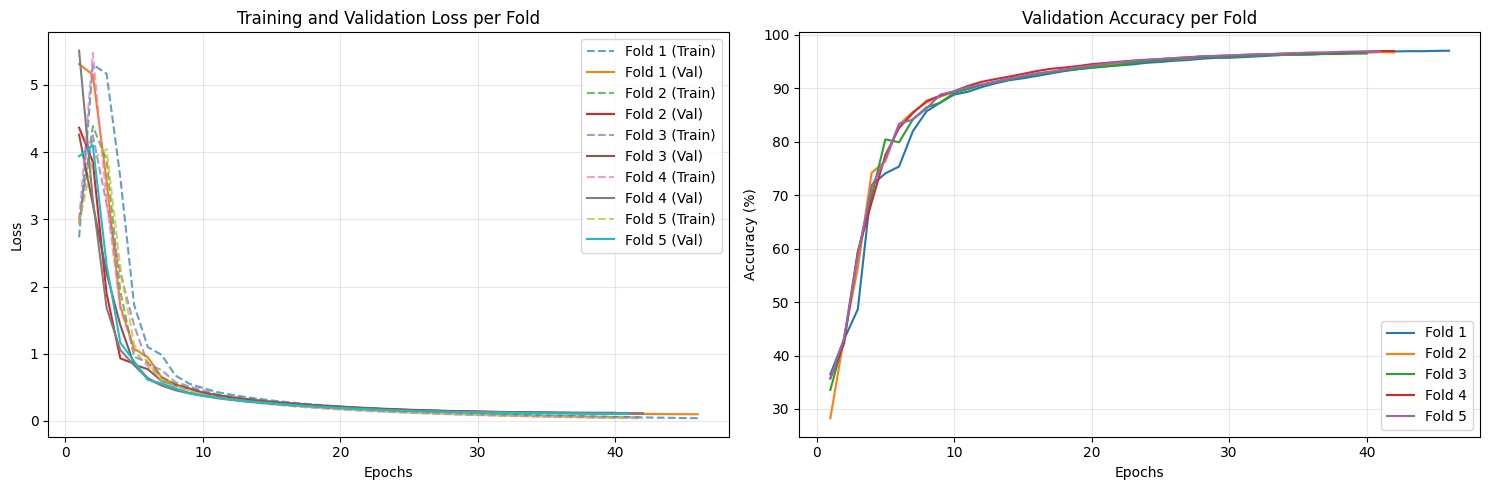


Trial 4 completed:
Parameters: {'n_neurons': 170, 'eta_minus': 0.3, 'eta_plus': 1.1}
Average accuracy across folds: 96.8417 ± 0.1917
Average validation loss: 0.1100 ± 0.0073
Average convergence epochs: 42.20 ± 2.04

Trial 5/10
Testing parameters: {'n_neurons': 170, 'eta_minus': 0.3, 'eta_plus': 1.05}
FOLD 1/5
Epoch [1/300], Train loss: 2.9295, Val Loss: 3.9749, Val Acc: 44.45%
Epoch [2/300], Train loss: 3.9791, Val Loss: 3.6317, Val Acc: 53.95%
Epoch [3/300], Train loss: 3.6009, Val Loss: 2.7745, Val Acc: 65.34%
Epoch [4/300], Train loss: 2.7709, Val Loss: 1.7926, Val Acc: 76.33%
Epoch [5/300], Train loss: 1.7870, Val Loss: 0.9635, Val Acc: 78.49%
Epoch [6/300], Train loss: 0.9494, Val Loss: 0.6550, Val Acc: 81.92%
Epoch [7/300], Train loss: 0.6557, Val Loss: 0.5632, Val Acc: 84.14%
Epoch [8/300], Train loss: 0.5672, Val Loss: 0.4672, Val Acc: 86.61%
Epoch [9/300], Train loss: 0.4633, Val Loss: 0.4272, Val Acc: 88.00%
Epoch [10/300], Train loss: 0.4198, Val Loss: 0.3858, Val Acc: 89.1

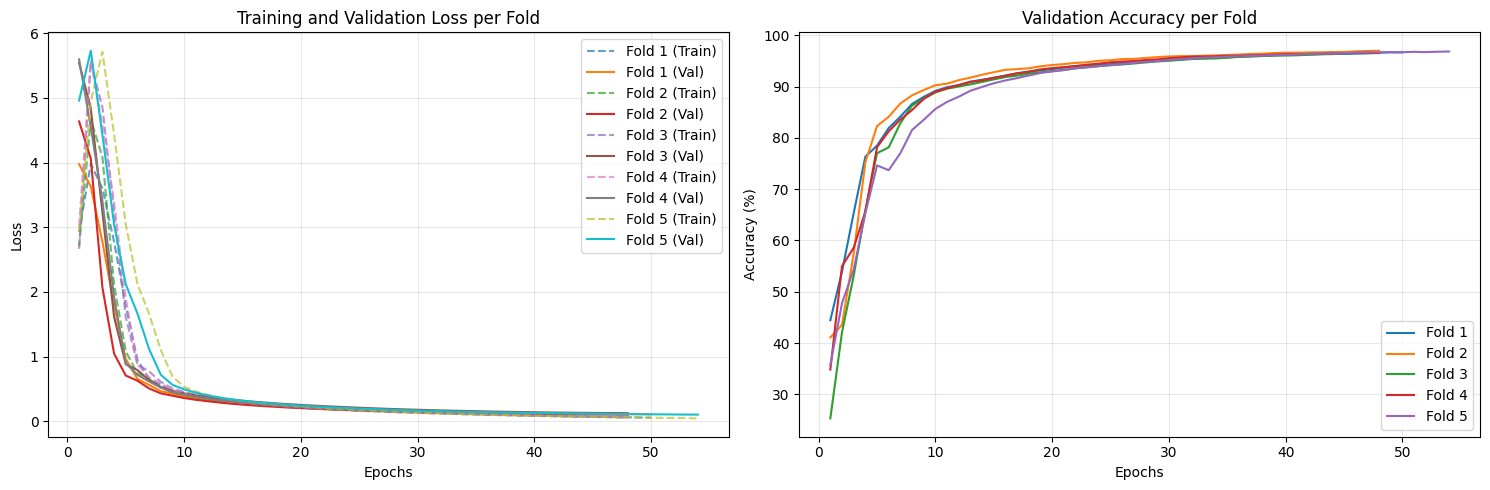


Trial 5 completed:
Parameters: {'n_neurons': 170, 'eta_minus': 0.3, 'eta_plus': 1.05}
Average accuracy across folds: 96.7146 ± 0.1748
Average validation loss: 0.1129 ± 0.0086
Average convergence epochs: 49.60 ± 2.33

Trial 6/10
Testing parameters: {'n_neurons': 170, 'eta_minus': 0.25, 'eta_plus': 1.1}
FOLD 1/5
Epoch [1/300], Train loss: 2.7781, Val Loss: 4.9459, Val Acc: 28.99%
Epoch [2/300], Train loss: 4.9926, Val Loss: 4.7714, Val Acc: 48.26%
Epoch [3/300], Train loss: 4.8253, Val Loss: 2.7521, Val Acc: 57.42%
Epoch [4/300], Train loss: 2.7895, Val Loss: 1.4441, Val Acc: 68.05%
Epoch [5/300], Train loss: 1.4775, Val Loss: 0.9327, Val Acc: 76.57%
Epoch [6/300], Train loss: 0.9613, Val Loss: 0.7079, Val Acc: 80.23%
Epoch [7/300], Train loss: 0.7346, Val Loss: 0.5663, Val Acc: 83.59%
Epoch [8/300], Train loss: 0.5944, Val Loss: 0.4739, Val Acc: 86.59%
Epoch [9/300], Train loss: 0.5022, Val Loss: 0.4270, Val Acc: 87.67%
Epoch [10/300], Train loss: 0.4517, Val Loss: 0.3912, Val Acc: 88.

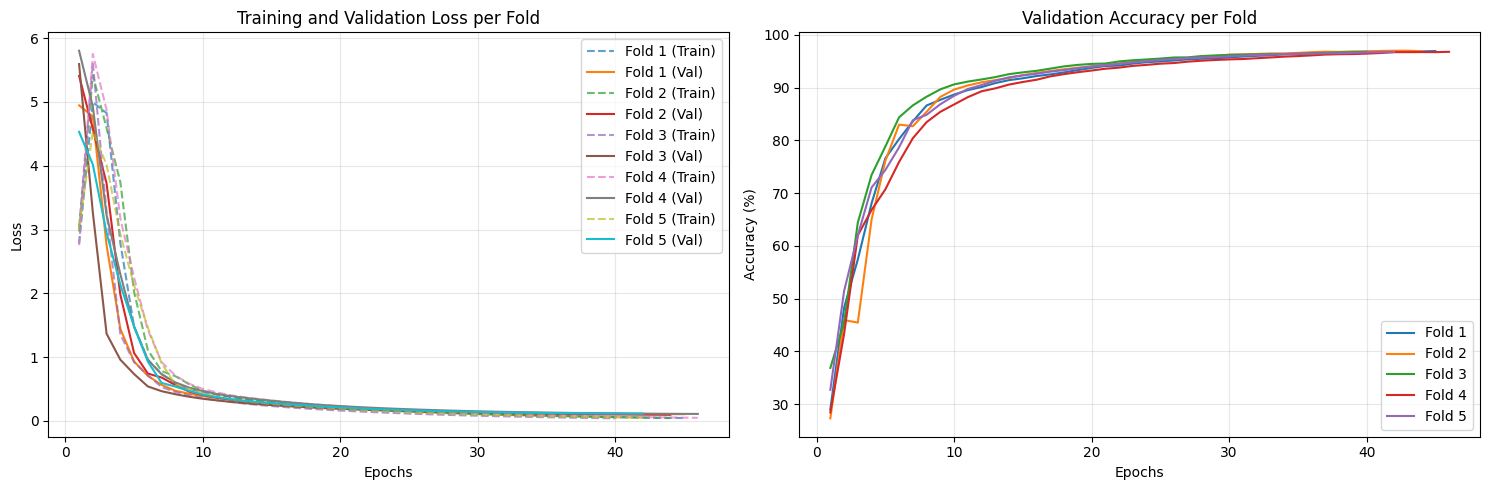


Trial 6 completed:
Parameters: {'n_neurons': 170, 'eta_minus': 0.25, 'eta_plus': 1.1}
Average accuracy across folds: 96.8125 ± 0.0754
Average validation loss: 0.1081 ± 0.0060
Average convergence epochs: 43.40 ± 2.15

Trial 7/10
Testing parameters: {'n_neurons': 150, 'eta_minus': 0.2, 'eta_plus': 1.15}
FOLD 1/5
Epoch [1/300], Train loss: 2.7796, Val Loss: 4.3221, Val Acc: 28.04%
Epoch [2/300], Train loss: 4.3388, Val Loss: 3.1120, Val Acc: 39.49%
Epoch [3/300], Train loss: 3.1222, Val Loss: 1.3927, Val Acc: 66.14%
Epoch [4/300], Train loss: 1.3864, Val Loss: 1.2830, Val Acc: 68.23%
Epoch [5/300], Train loss: 1.2911, Val Loss: 0.9651, Val Acc: 74.50%
Epoch [6/300], Train loss: 0.9756, Val Loss: 0.7012, Val Acc: 83.16%
Epoch [7/300], Train loss: 0.7114, Val Loss: 0.6024, Val Acc: 84.39%
Epoch [8/300], Train loss: 0.6168, Val Loss: 0.5086, Val Acc: 86.33%
Epoch [9/300], Train loss: 0.5201, Val Loss: 0.4367, Val Acc: 88.44%
Epoch [10/300], Train loss: 0.4448, Val Loss: 0.3928, Val Acc: 89.

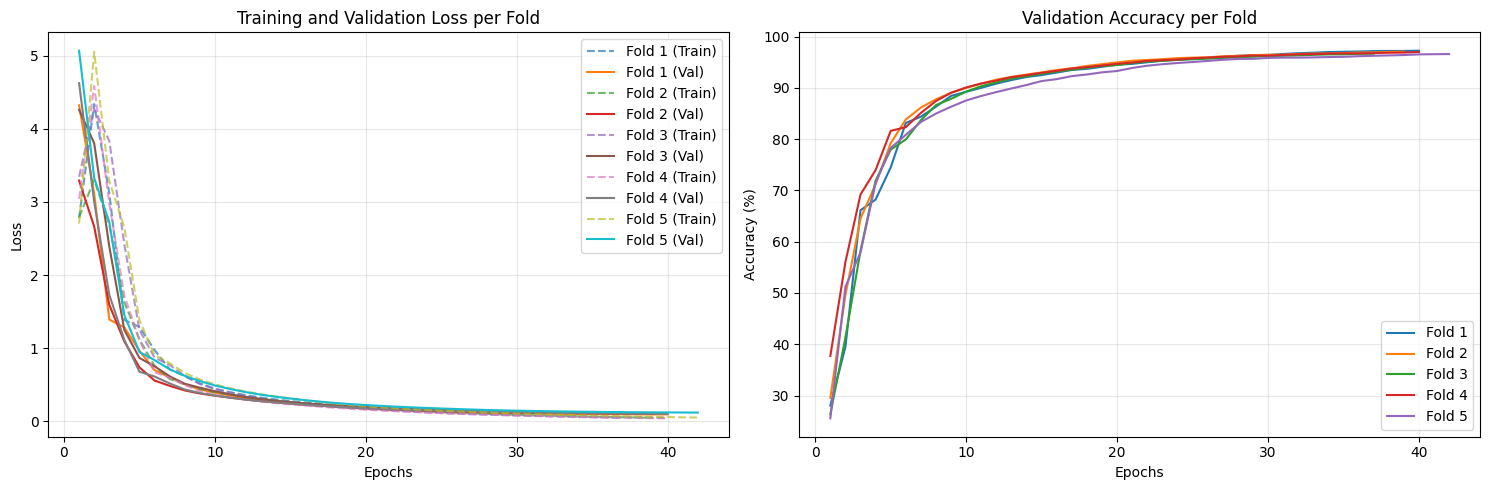


Trial 7 completed:
Parameters: {'n_neurons': 150, 'eta_minus': 0.2, 'eta_plus': 1.15}
Average accuracy across folds: 96.9125 ± 0.2495
Average validation loss: 0.1083 ± 0.0105
Average convergence epochs: 39.60 ± 1.62

Trial 8/10
Testing parameters: {'n_neurons': 250, 'eta_minus': 0.25, 'eta_plus': 1.15}
FOLD 1/5
Epoch [1/300], Train loss: 2.6729, Val Loss: 7.2417, Val Acc: 30.52%
Epoch [2/300], Train loss: 7.2759, Val Loss: 7.9488, Val Acc: 36.67%
Epoch [3/300], Train loss: 7.9933, Val Loss: 4.9160, Val Acc: 49.52%
Epoch [4/300], Train loss: 4.9916, Val Loss: 2.3379, Val Acc: 60.53%
Epoch [5/300], Train loss: 2.3813, Val Loss: 1.2264, Val Acc: 75.35%
Epoch [6/300], Train loss: 1.2481, Val Loss: 0.8750, Val Acc: 81.48%
Epoch [7/300], Train loss: 0.8902, Val Loss: 0.7386, Val Acc: 82.62%
Epoch [8/300], Train loss: 0.7543, Val Loss: 0.5868, Val Acc: 85.77%
Epoch [9/300], Train loss: 0.6039, Val Loss: 0.4667, Val Acc: 88.54%
Epoch [10/300], Train loss: 0.4862, Val Loss: 0.4051, Val Acc: 89

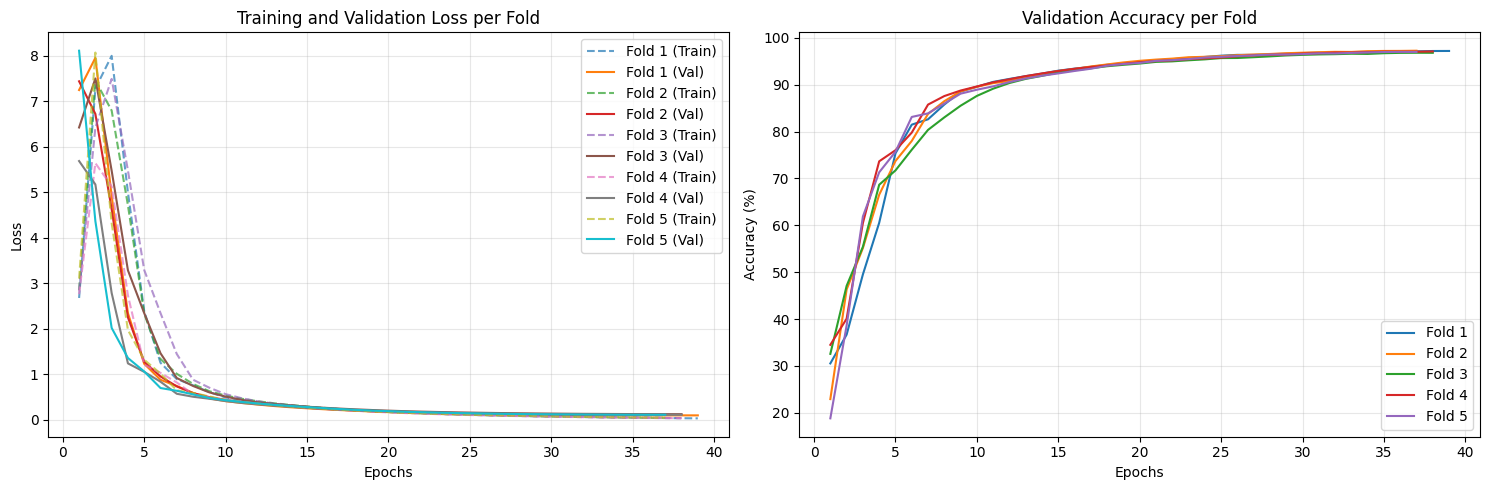


Trial 8 completed:
Parameters: {'n_neurons': 250, 'eta_minus': 0.25, 'eta_plus': 1.15}
Average accuracy across folds: 97.0771 ± 0.1597
Average validation loss: 0.1055 ± 0.0086
Average convergence epochs: 37.80 ± 0.75

Trial 9/10
Testing parameters: {'n_neurons': 150, 'eta_minus': 0.25, 'eta_plus': 1.05}
FOLD 1/5
Epoch [1/300], Train loss: 2.7489, Val Loss: 5.6836, Val Acc: 24.95%
Epoch [2/300], Train loss: 5.6544, Val Loss: 3.7472, Val Acc: 39.52%
Epoch [3/300], Train loss: 3.7247, Val Loss: 1.6411, Val Acc: 62.39%
Epoch [4/300], Train loss: 1.6578, Val Loss: 0.8390, Val Acc: 77.24%
Epoch [5/300], Train loss: 0.8613, Val Loss: 0.7428, Val Acc: 80.14%
Epoch [6/300], Train loss: 0.7673, Val Loss: 0.5857, Val Acc: 84.06%
Epoch [7/300], Train loss: 0.6079, Val Loss: 0.5001, Val Acc: 86.14%
Epoch [8/300], Train loss: 0.5196, Val Loss: 0.4517, Val Acc: 87.41%
Epoch [9/300], Train loss: 0.4676, Val Loss: 0.4127, Val Acc: 88.41%
Epoch [10/300], Train loss: 0.4263, Val Loss: 0.3821, Val Acc: 8

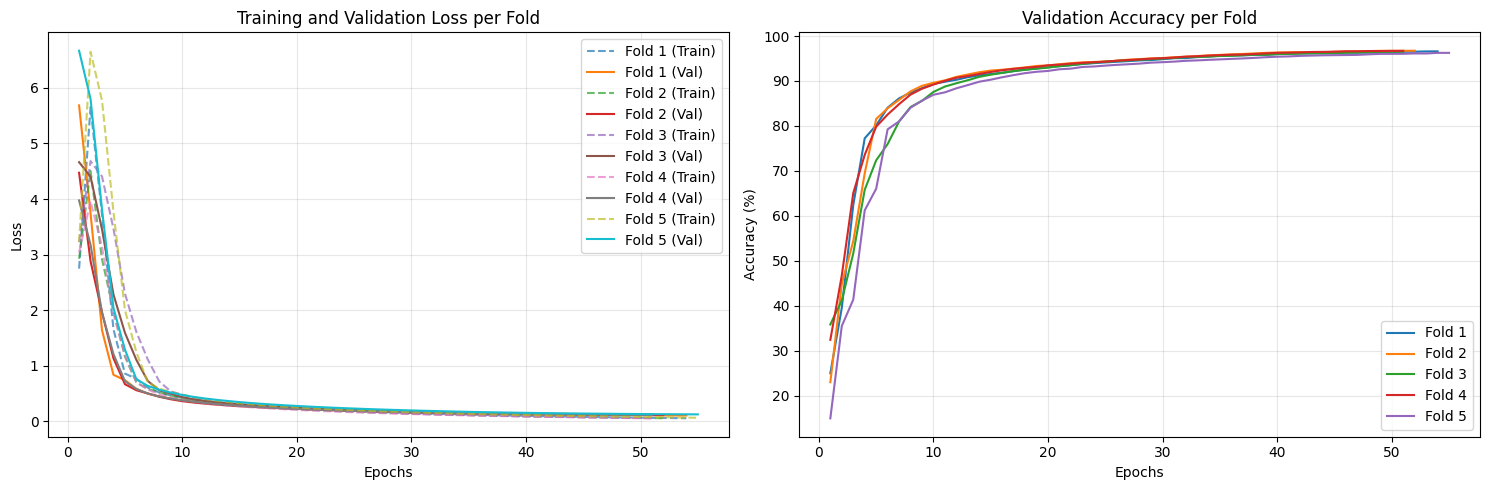


Trial 9 completed:
Parameters: {'n_neurons': 150, 'eta_minus': 0.25, 'eta_plus': 1.05}
Average accuracy across folds: 96.5604 ± 0.1725
Average validation loss: 0.1183 ± 0.0071
Average convergence epochs: 52.60 ± 1.62

Trial 10/10
Testing parameters: {'n_neurons': 250, 'eta_minus': 0.5, 'eta_plus': 1.07}
FOLD 1/5
Epoch [1/300], Train loss: 2.8893, Val Loss: 5.3259, Val Acc: 36.26%
Epoch [2/300], Train loss: 5.3141, Val Loss: 4.8778, Val Acc: 49.43%
Epoch [3/300], Train loss: 4.8680, Val Loss: 2.4431, Val Acc: 62.65%
Epoch [4/300], Train loss: 2.4619, Val Loss: 1.2028, Val Acc: 72.03%
Epoch [5/300], Train loss: 1.2152, Val Loss: 1.0778, Val Acc: 74.61%
Epoch [6/300], Train loss: 1.0956, Val Loss: 0.6757, Val Acc: 82.09%
Epoch [7/300], Train loss: 0.6987, Val Loss: 0.4743, Val Acc: 87.27%
Epoch [8/300], Train loss: 0.4936, Val Loss: 0.4530, Val Acc: 87.39%
Epoch [9/300], Train loss: 0.4627, Val Loss: 0.3662, Val Acc: 89.92%
Epoch [10/300], Train loss: 0.3729, Val Loss: 0.3441, Val Acc: 9

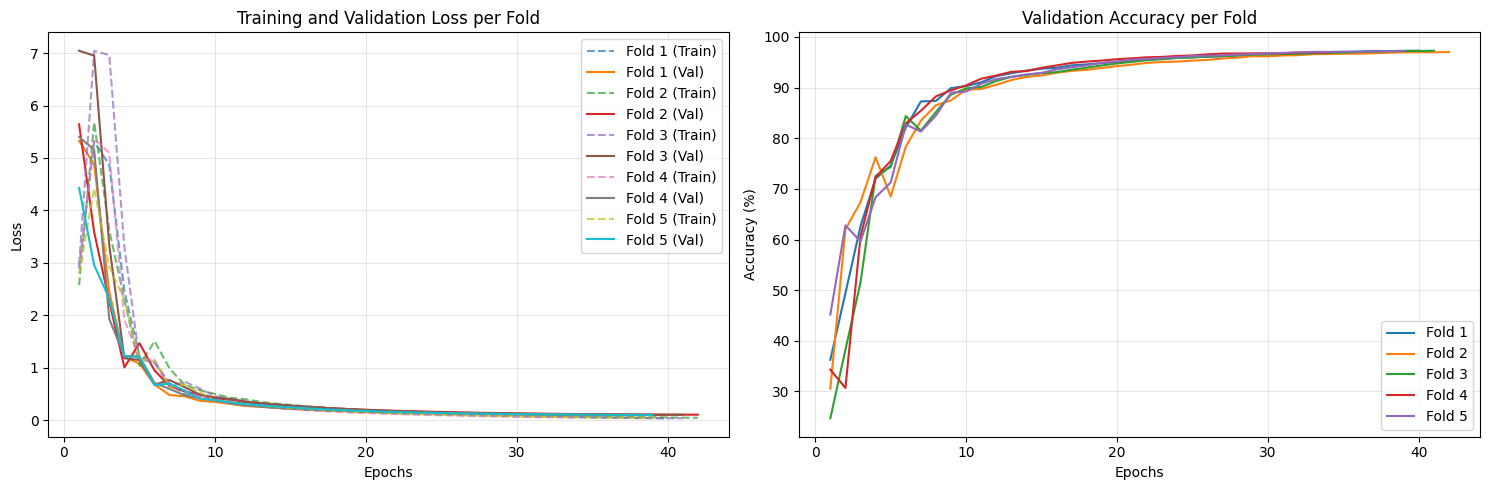


Trial 10 completed:
Parameters: {'n_neurons': 250, 'eta_minus': 0.5, 'eta_plus': 1.07}
Average accuracy across folds: 97.1458 ± 0.1514
Average validation loss: 0.0993 ± 0.0053
Average convergence epochs: 39.20 ± 2.79


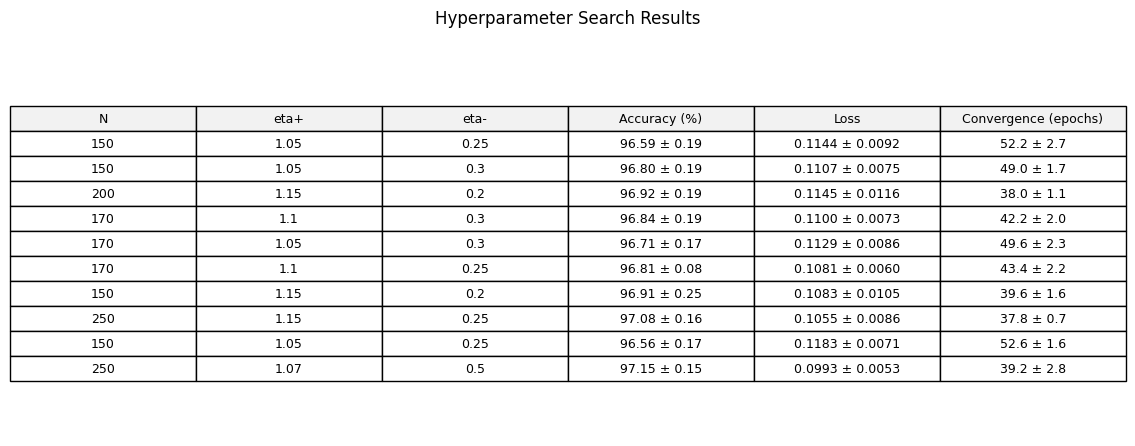


Best trial results:
Parameters: {'n_neurons': 250, 'eta_minus': 0.5, 'eta_plus': 1.07}
Accuracy: 97.1458 ± 0.1514
Validation loss: 0.0993 ± 0.0053
Convergence epochs: 39.20 ± 2.79


In [4]:
seed = 42

set_seed(seed)

device = get_device()

# Hyperparameters for the random search
n_trials = 10

# Hyperparameters for the k-fold cross-validation
k_folds = 5

# Hyperparameters for the neural network
input_size = 28 * 28
num_classes = 10

# Hyperparameters for the training
num_epochs = 300
train_batch_size = None # degined after splitting the dataset (batch learning)
val_batch_size = None # defined after splitting the dataset (batch learning)
learning_rate = 0.01

# Hyperparameters for the Early Stopping
patience = 3
min_delta = 0.0040

trial_results = []

param_space = {
    'n_neurons': [150, 170, 200, 220, 250],
    'eta_minus': [0.5, 0.4, 0.3, 0.25, 0.2],
    'eta_plus': [1.2, 1.15, 1.1, 1.07, 1.05],
}

for trial in range(n_trials):
    params = {
        'n_neurons': random.choice(param_space['n_neurons']),
        'eta_minus': float(np.random.choice(param_space['eta_minus'])),
        'eta_plus': float(np.random.choice(param_space['eta_plus'])),
    }

    print(f"\nTrial {trial+1}/{n_trials}")
    print(f"Testing parameters: {params}")
    
    fold_train_losses = []
    fold_val_losses = []
    fold_val_accuracies = []
    fold_convergence_epochs = []
    
    kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)
        
    targets = train_dataset.dataset.targets[train_dataset.indices]
    
    for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset, targets)):
        print(f'FOLD {fold+1}/{k_folds}')
        
        train_subset = torch.utils.data.Subset(train_dataset, train_ids)
        val_subset = torch.utils.data.Subset(train_dataset, val_ids)
        
        train_batch_size = len(train_subset)
        val_batch_size = len(val_subset)

        train_loader = create_dataloaders(train_subset, train_batch_size, num_workers=8, shuffle=True)
        val_loader = create_dataloaders(val_subset, val_batch_size, num_workers=8, shuffle=False)

        model, criterion, optimizer = create_model(
            input_size, params['n_neurons'], num_classes, 
            learning_rate, params['eta_minus'], params['eta_plus'], 
            device
        )
        
        train_losses, val_losses, val_accuracies = train_model(
            model, train_loader, val_loader, 
            criterion, optimizer, device, 
            num_epochs, patience, min_delta,
        )

        fold_train_losses.append(train_losses)
        fold_val_losses.append(val_losses)
        fold_val_accuracies.append(val_accuracies)
        fold_convergence_epochs.append(len(train_losses))
    
    plot_fold_results(fold_train_losses, fold_val_losses, fold_val_accuracies)

    final_fold_accuracies = [acc[-1] for acc in fold_val_accuracies]
    avg_accuracy = np.mean(final_fold_accuracies)
    std_accuracy = np.std(final_fold_accuracies)

    final_val_losses = [losses[-1] for losses in fold_val_losses]
    avg_loss = np.mean(final_val_losses)
    std_loss = np.std(final_val_losses)
    
    avg_convergence = np.mean(fold_convergence_epochs)
    std_convergence = np.std(fold_convergence_epochs)
    
    trial_results.append((params, avg_accuracy, std_accuracy, avg_loss, std_loss, avg_convergence, std_convergence))
    
    print(f"\nTrial {trial + 1} completed:")
    print(f"Parameters: {params}")
    print(f"Average accuracy across folds: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"Average validation loss: {avg_loss:.4f} ± {std_loss:.4f}")
    print(f"Average convergence epochs: {avg_convergence:.2f} ± {std_convergence:.2f}")

show_kfold_results(trial_results)

best_trial = max(trial_results, key=lambda x: x[1])
print("\nBest trial results:")
print(f"Parameters: {best_trial[0]}")
print(f"Accuracy: {best_trial[1]:.4f} ± {best_trial[2]:.4f}")
print(f"Validation loss: {best_trial[3]:.4f} ± {best_trial[4]:.4f}")
print(f"Convergence epochs: {best_trial[5]:.2f} ± {best_trial[6]:.2f}")

### Defenition and training of a model with the best hyperparameter found

In [ ]:
best_params = best_trial[0]

device = get_device()

# Hyperparameters for the neural network
input_size = 28 * 28
num_classes = 10

# Hyperparameters for the training
num_epochs = 300
train_batch_size = len(train_dataset) 
val_batch_size = len(val_dataset)
learning_rate = 0.01

# Hyperparameters for the Early Stopping
patience = 3
min_delta = 0.040

train_loader = create_dataloaders(train_dataset, train_batch_size, num_workers=8, shuffle=True) 
test_loader = create_dataloaders(test_dataset, val_batch_size, num_workers=8, shuffle=False)

best_model, criterion, optimizer = create_model(
    input_size=input_size,
    n_neurons=best_params['n_neurons'],
    num_classes=num_classes, 
    learning_rate=learning_rate,
    eta_minus=best_params['eta_minus'],
    eta_plus=best_params['eta_plus'],
    device=device
)

train_losses, val_losses, val_accuracies = train_model(
    best_model, train_loader, val_loader, 
    criterion, optimizer, device, 
    num_epochs, patience, min_delta,
)

plot_results(train_losses, val_losses, val_accuracies)

### Best model testing

In [ ]:
_, acc = validate_model(best_model, test_loader, criterion, device)
print(f'Test accuracy: {acc:.2f}%')

plot_confusion_matrix(model, test_loader, device)